In [1]:
!pip install "numpy<1.23" scipy

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception # type: ignore
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models, losses, optimizers

In [3]:
img = load_img("./data/train/ambarella/ambarella_00003.jpg", target_size=(299,299))

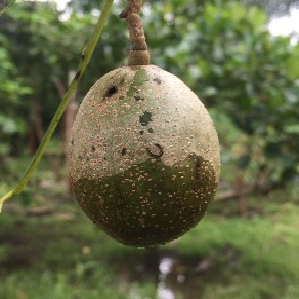

In [4]:
img

In [5]:
np.array(img).shape

(299, 299, 3)

# Train model

In [6]:
def make_model():
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(299, 299, 3)
    )
    
    ########################
    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training = False)
    vectors = layers.GlobalAveragePooling2D()(base)
    inner = layers.Dense(64, activation='relu')(vectors)
    outputs = layers.Dense(5)(inner)
    model = keras.Model(inputs, outputs)
    ########################
    
    # optimizer = optimizers.Adam(learning_rate=learning_rate)
    loss = losses.CategoricalCrossentropy(from_logits=True)

    # model.compile(
    #     optimizer=optimizer,
    #     loss=loss,
    #     metrics=['accuracy']
    # )
    model.compile(loss = loss, metrics=['accuracy'])

    return model



In [3]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_ds = train_gen.flow_from_directory(
    './data/train',
    target_size=(299, 299),
    batch_size=32
)


val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = train_gen.flow_from_directory(
    './data/test',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

Found 513 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


In [8]:
model = make_model()

2025-01-07 01:18:18.803151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-07 01:18:18.809921: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-07 01:18:18.810127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-01-07 01:18:18.810618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [9]:
history = model.fit(train_ds, validation_data = val_ds)

2025-01-07 01:18:28.902880: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2025-01-07 01:18:29.524816: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-07 01:18:29.525519: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-07 01:18:29.525556: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-01-07 01:18:29.526164: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-07 01:18:29.526251: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


17/17 [==============================] - 30s 1s/step - loss: 15.1173 - accuracy: 0.2320 - val_loss: 1.6094 - val_accuracy: 0.2000


In [10]:
history

Hyperparameter i will try:
- inner dense layer size
- learning rate
- epochs(using checkpoint)

And try another model if i have enough time

# Learning rate Optimize

In [4]:
score = {}
def make_model(
        base_model = Xception(
            weights='imagenet',
            include_top=False,
            input_shape=(299, 299, 3)
        ),
        dense_inner_size = 64,
        learning_rate = 0.001
):
    
    ########################
    inputs = keras.Input(shape=(299, 299, 3))
    base = base_model(inputs, training = False)
    vectors = layers.GlobalAveragePooling2D()(base)
    inner = layers.Dense(dense_inner_size, activation='relu')(vectors)
    outputs = layers.Dense(5)(inner)
    model = keras.Model(inputs, outputs)

    '][==]'
    ########################
    
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    loss = losses.CategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    model.compile(loss = loss, metrics=['accuracy'])

    return model

for lr in [0.0001, 0.001, 0.01, 0.1]:
    model = make_model(
        learning_rate=lr
    )

    early_stopping = keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        patience = 5,
        restore_best_weights=True
    )

    history = model.fit(train_ds, epochs = 30, validation_data = val_ds, callbacks=[early_stopping])
    score[lr] = history.history


c:\Users\super\miniconda3\envs\py311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
 1/17 ━━━━━━━━━━━━━━━━━━━━ 8:23 31s/step - accuracy: 0.2812 - loss: 1.5249

KeyboardInterrupt: 

In [ ]:
score